In [1]:
import numpy as np
import matplotlib.pyplot as plt
from ortools_solver import CVRP_solver
from utils import random_choose_candidate, distance_calculator, calculate_distance_matrix, show_matrix, get_optimized_sequence
from QAP_solver import calculate_S_E, calculate_D_prime, calculate_T
import pygmtools as pygm

/u/yq/chem1906/anaconda3/envs/pipette_scheduling/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
D = np.ones((96,96))
for i in range(96):
    for j in range(96):
        if i//8 == j//8:
            if i-j == -1:
                D[i,j] = 0

In [3]:
# row is the source, column is the destination
a= np.eye(96)
a = random_choose_candidate(96,96,4)
# randomly shuffle the rows
#np.random.shuffle(a)
# binarize the matrix as 0 and 1
a[a>0] = 1
# generate the job pair
jobs = np.argwhere(a)
#distance_matrix = calculate_distance_matrix(jobs)
#S,E = calculate_S_E(jobs)
#D_prime = calculate_D_prime(D, S, E)

In [4]:
a = random_choose_candidate(96,96,4)
jobs = np.argwhere(a)
volume = [a[i,j] for i,j in jobs]
volume = np.array(volume)
volume

array([0.26, 0.1 , 0.26, 0.38, 0.36, 0.32, 0.06, 0.26, 0.32, 0.43, 0.21,
       0.05, 0.39, 0.05, 0.05, 0.51, 0.07, 0.34, 0.24, 0.34, 0.22, 0.17,
       0.08, 0.53, 0.4 , 0.44, 0.02, 0.14, 0.11, 0.47, 0.17, 0.25, 0.18,
       0.35, 0.2 , 0.27, 0.2 , 0.24, 0.28, 0.29, 0.09, 0.01, 0.74, 0.16,
       0.01, 0.37, 0.32, 0.3 , 0.13, 0.34, 0.15, 0.38, 0.18, 0.25, 0.21,
       0.37, 0.05, 0.28, 0.44, 0.23, 0.4 , 0.02, 0.49, 0.09, 0.35, 0.28,
       0.22, 0.15, 0.21, 0.36, 0.14, 0.29, 0.04, 0.64, 0.21, 0.1 , 0.06,
       0.65, 0.13, 0.16, 0.2 , 0.28, 0.4 , 0.12, 0.27, 0.23, 0.5 , 0.47,
       0.04, 0.36, 0.12, 0.25, 0.35, 0.33, 0.07, 0.25, 0.17, 0.3 , 0.29,
       0.4 , 0.1 , 0.14, 0.36, 0.14, 0.16, 0.36, 0.34, 0.06, 0.28, 0.52,
       0.15, 0.3 , 0.2 , 0.25, 0.25, 0.38, 0.26, 0.32, 0.04, 0.18, 0.25,
       0.4 , 0.18, 0.07, 0.33, 0.09, 0.51, 0.23, 0.26, 0.39, 0.12, 0.26,
       0.11, 0.21, 0.42, 0.47, 0.12, 0.07, 0.35, 0.47, 0.2 , 0.2 , 0.13,
       0.25, 0.2 , 0.1 , 0.45, 0.06, 0.46, 0.07, 0.

In [5]:
def CVRP_QAP(jobs,iteration=5):
    output_P = np.eye(96)
    S,E = calculate_S_E(jobs)
    D_prime = calculate_D_prime(D, S, E)
    best_cost = float('inf')
    for i in range(iteration):
        # construct & update CVRP
        D_prime = np.vstack((np.zeros(D_prime.shape[0]), D_prime))
        D_prime = np.hstack((np.zeros((D_prime.shape[0], 1)), D_prime))
        
        # solve CVRP
        optimized_distance,recorder = CVRP_solver(D_prime.astype(np.int64), solving_time=2)
        
        optimized_seuqnecess = get_optimized_sequence(recorder)
        t = calculate_T(optimized_seuqnecess)
        D_prime = D_prime[1:,1:]
        # cost = trace (T^T * D_prime)
        cost = np.trace(np.dot(t.T,D_prime))
        print(f'iter={i}, cost={cost} after CVRP')
        
        # construct QAP
        A = np.dot(np.dot(E.T,t.T),E)
        B = D
        K = np.kron(1-B, A.T) # transform minimization into maximization
        
        # solve QAP
        P = pygm.ipfp((K + K.T),n1=96,n2=96, x0=np.eye(96)[None,:,:])

        # new_E = E * P
        new_E = np.dot(E,P)
        #new D_prime = S * D * S^T + new_E * D * new_E^T
        new_D_prime = np.dot(np.dot(S,D),S.T) + np.dot(np.dot(new_E,D),new_E.T)
        cost = np.trace(np.dot(t.T,new_D_prime))
        output_P = np.dot(output_P,P)
        print(f'iter={i}, cost={cost} after QAP')
        if best_cost > cost:
            best_cost = cost
            best_output_P = output_P

        # update params
        D_prime = new_D_prime
        E = new_E
    return best_cost, best_output_P

In [6]:
def print_command(flatten_sequence, jobs):
    command_line = []
    for i in range(flatten_sequence.shape[0]):
    # add the command line base on the index, set the volume as 20ul by default
        command_line.append(
        ['source',
            jobs[flatten_sequence[i],0]+1,
            'dest',
            jobs[flatten_sequence[i],1]+1,
            20])
    command_line = np.array(command_line) 
    return command_line

In [7]:
test_cost, test_P = CVRP_QAP(jobs,iteration=20)

Objective: 347
iter=0, cost=347.0 after CVRP
iter=0, cost=347.0 after QAP
Objective: 350
iter=1, cost=350.0 after CVRP


/u/yq/chem1906/anaconda3/envs/pipette_scheduling/lib/python3.9/site-packages/pygmtools/numpy_backend.py:308: RuntimeWarning: divide by zero encountered in divide
  t0 = - alpha / beta
/u/yq/chem1906/anaconda3/envs/pipette_scheduling/lib/python3.9/site-packages/pygmtools/numpy_backend.py:309: RuntimeWarning: invalid value encountered in multiply
  v = np.where(np.logical_or(beta >= 0, t0 >= 1), binary_v, v + t0 * (binary_v - v))


iter=1, cost=348.0 after QAP
Objective: 348
iter=2, cost=348.0 after CVRP


/u/yq/chem1906/anaconda3/envs/pipette_scheduling/lib/python3.9/site-packages/pygmtools/numpy_backend.py:308: RuntimeWarning: invalid value encountered in divide
  t0 = - alpha / beta


iter=2, cost=346.0 after QAP
Objective: 337
iter=3, cost=337.0 after CVRP
iter=3, cost=337.0 after QAP
Objective: 340
iter=4, cost=340.0 after CVRP
iter=4, cost=340.0 after QAP
Objective: 340
iter=5, cost=340.0 after CVRP
iter=5, cost=340.0 after QAP
Objective: 340
iter=6, cost=340.0 after CVRP
iter=6, cost=340.0 after QAP
Objective: 340
iter=7, cost=340.0 after CVRP
iter=7, cost=340.0 after QAP
Objective: 340
iter=8, cost=340.0 after CVRP
iter=8, cost=340.0 after QAP
Objective: 340
iter=9, cost=340.0 after CVRP
iter=9, cost=340.0 after QAP
Objective: 340
iter=10, cost=340.0 after CVRP
iter=10, cost=340.0 after QAP
Objective: 340
iter=11, cost=340.0 after CVRP
iter=11, cost=340.0 after QAP
Objective: 340
iter=12, cost=340.0 after CVRP
iter=12, cost=340.0 after QAP
Objective: 340
iter=13, cost=340.0 after CVRP
iter=13, cost=340.0 after QAP
Objective: 340
iter=14, cost=340.0 after CVRP
iter=14, cost=340.0 after QAP
Objective: 340
iter=15, cost=340.0 after CVRP
iter=15, cost=340.0 after Q

In [8]:
update_a = np.dot(a,test_P)
jobs = np.argwhere(update_a)
distance_matrix = calculate_distance_matrix(jobs)
VRP_distance, VRP_recorder = CVRP_solver(distance_matrix)
recorder = get_optimized_sequence(VRP_recorder)

Objective: 350


In [9]:
sequence = recorder.flatten()
sequence = sequence[sequence!=-1] -1
command_line = print_command(sequence,jobs)
np.savetxt('optimized_command_line.csv',command_line,fmt='%s',delimiter=',')

In [10]:
jobs = np.argwhere(a)
unoptimized_command_line = print_command(np.array(range(jobs.shape[0])),jobs)
np.savetxt('unoptimized_command_line.csv',unoptimized_command_line,fmt='%s',delimiter=',')

In [11]:
stat = []
for i in range(1,20):
    experiments = random_choose_candidate(96,96,i)
    jobs = np.argwhere(experiments)
    distance_matrix = calculate_distance_matrix(jobs)
    optimized_distance,recorder = CVRP_QAP(jobs)
    VRP_distance, _ = CVRP_solver(distance_matrix)
    non_optimized_distance = distance_calculator(jobs)
    stat.append((i,non_optimized_distance,optimized_distance, VRP_distance))
stat = np.array(stat)

Objective: 91
iter=0, cost=91.0 after CVRP
iter=0, cost=71.0 after QAP
Objective: 64
iter=1, cost=64.0 after CVRP
iter=1, cost=62.0 after QAP
Objective: 62
iter=2, cost=62.0 after CVRP
iter=2, cost=62.0 after QAP
Objective: 63
iter=3, cost=63.0 after CVRP
iter=3, cost=60.0 after QAP
Objective: 60
iter=4, cost=60.0 after CVRP
iter=4, cost=59.0 after QAP
Objective: 86
Objective: 188
iter=0, cost=188.0 after CVRP
iter=0, cost=170.0 after QAP
Objective: 169
iter=1, cost=169.0 after CVRP
iter=1, cost=166.0 after QAP
Objective: 163
iter=2, cost=163.0 after CVRP
iter=2, cost=161.0 after QAP
Objective: 170
iter=3, cost=170.0 after CVRP
iter=3, cost=168.0 after QAP
Objective: 159
iter=4, cost=159.0 after CVRP
iter=4, cost=159.0 after QAP
Objective: 188
Objective: 276
iter=0, cost=276.0 after CVRP
iter=0, cost=273.0 after QAP
Objective: 277
iter=1, cost=277.0 after CVRP
iter=1, cost=270.0 after QAP
Objective: 265
iter=2, cost=265.0 after CVRP
iter=2, cost=263.0 after QAP
Objective: 273
iter=3, c

In [ ]:
from utils import random_choose_candidate, distance_calculator, calculate_distance_matrix, CVRP_solver
stat = []
for i in range(1,27):
    experiments = random_choose_candidate(96,96,i)
    jobs = np.argwhere(experiments)
    distance_matrix = calculate_distance_matrix(non_zero_pos)
    optimized_distance,recorder = CVRP_solver(distance_matrix)
    non_optimized_distance = distance_calculator(non_zero_pos)
    stat.append((i,non_optimized_distance,optimized_distance))
stat = np.array(stat)

ImportError: cannot import name 'calculate_distance' from 'utils' (/home/yq-mew/yq/chem1906/Projects/pipette_scheduling/notebooks/utils.py)

In [ ]:
sequences = CVRP_QAP(jobs,iteration=5)
sequences

In [ ]:
o_sequences = get_optimized_sequence(sequences)

In [ ]:
CVRP_distance = np.zeros((96,96))

for i in range(96):
    for j in range(96):
        # take the arraies whose second column equal i
        jobs_i = jobs[jobs[:,1] == i]
        # take the arraies whose second column equal j
        jobs_j = jobs[jobs[:,1] == j]
        jobs_ij = np.vstack((jobs_i,jobs_j))
        distance_ij = calculate_distance(jobs_ij)
        optimized_distance_ij,recorder_ij = CVRP_solver(distance_ij,solving_time=1)
        CVRP_distance[i,j] = optimized_distance_ij

In [13]:
optimized_distance,recorder = CVRP_solver(distance_matrix,solving_time=2)

TypeError: cannot unpack non-iterable NoneType object

In [14]:
optimized_seuqnecess = get_optimized_sequence(recorder)
t = calculate_T(optimized_seuqnecess)
D_prime = D_prime[1:,1:]
# cost = trace (T^T * D_prime)
cost = np.trace(np.dot(t.T,D_prime))
cost

ValueError: index can't contain negative values

In [9]:
# remove the first row and column of D_prime
stat = stat.round(2)
stat

array([[1.000e+00, 8.400e+01, 5.700e+01, 8.900e+01],
       [2.000e+00, 2.420e+02, 1.670e+02, 1.830e+02],
       [3.000e+00, 4.130e+02, 2.440e+02, 2.740e+02],
       [4.000e+00, 6.110e+02, 3.580e+02, 3.590e+02],
       [5.000e+00, 7.380e+02, 4.400e+02, 4.380e+02],
       [6.000e+00, 8.940e+02, 5.230e+02, 5.220e+02],
       [7.000e+00, 1.049e+03, 6.080e+02, 5.970e+02],
       [8.000e+00, 1.216e+03, 7.150e+02, 7.090e+02],
       [9.000e+00, 1.365e+03, 7.790e+02, 7.590e+02],
       [1.000e+01, 1.485e+03, 8.480e+02, 8.330e+02],
       [1.100e+01, 1.634e+03, 9.440e+02, 9.290e+02],
       [1.200e+01, 1.789e+03, 1.037e+03, 1.030e+03],
       [1.300e+01, 1.927e+03, 1.077e+03, 1.068e+03],
       [1.400e+01, 2.068e+03, 1.177e+03, 1.174e+03],
       [1.500e+01, 2.207e+03, 1.271e+03, 1.266e+03],
       [1.600e+01, 2.312e+03, 1.327e+03, 1.325e+03],
       [1.700e+01, 2.468e+03, 1.396e+03, 1.388e+03],
       [1.800e+01, 2.608e+03, 1.482e+03, 1.477e+03],
       [1.900e+01, 2.726e+03, 1.565e+03, 1.560

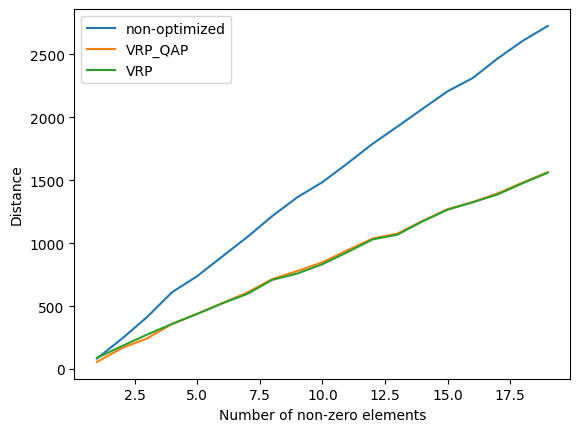

In [10]:
# plot the result
plt.plot(stat[:,0],stat[:,1],label='non-optimized')
plt.plot(stat[:,0],stat[:,2],label='VRP_QAP')
plt.plot(stat[:,0],stat[:,3],label='VRP')
plt.legend()
plt.xlabel('Number of non-zero elements')
plt.ylabel('Distance')
plt.show()

In [ ]:
A = np.dot(np.dot(E.T,t.T),E)
B = D
# K = Kron(A,B)
K = np.kron(B, A.T)
K

In [ ]:
np.max(K)

In [ ]:
P = pygm.ipfp(-K,n1=96,n2=96, max_iter=100)
P = pygm.hungarian(P)
vec_P = P.T.reshape(-1, 1)
print(np.dot(np.dot(vec_P.T, -K), vec_P))

P = np.eye(96)
vec_P = P.T.reshape(-1, 1)
print(np.dot(np.dot(vec_P.T, -K), vec_P))


In [ ]:
np.trace(np.dot(np.dot(np.dot(t.T, S), D), S.T))

In [ ]:
np.trace(np.dot(np.dot(np.dot(np.dot(np.dot(t.T, E), P), D), P.T), E.T))